In [1]:
import importlib
from jax.scipy.linalg import inv, det, svd
import jax.numpy as jnp
from jax import random, jit, lax
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import jax
from jax_models import visualize_observations, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix, Lorenz96
from jax_filters import ensrf_steps
from jax.tree_util import Partial

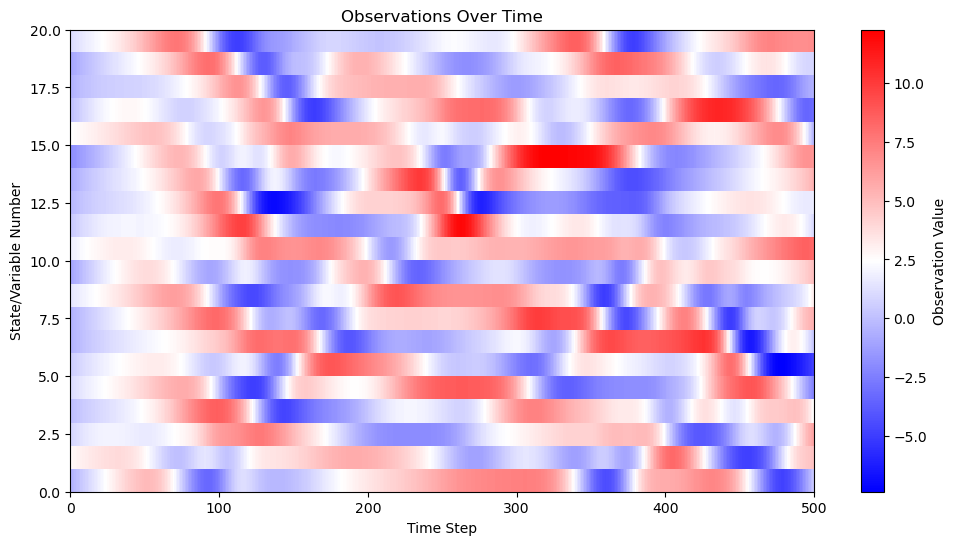

In [25]:

# Parameters
F = 8.0
dt = 0.01
num_steps = 500  # Number of time steps
n_timesteps = num_steps
J0 = 0
n = 20   # Number of state variables
Q = 0.1 * jnp.eye(n)  # Process noise covariance
R_matrix = 0.1 * jnp.eye(n)#make_spd_matrix(n)  # Generating a symmetric positive definite matrix for R
R = jnp.array(R_matrix)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix


#N = 10
n_ensemble = 20
observation_interval = 5
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = 8)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
key = random.PRNGKey(0)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

# Visualize the observations
visualize_observations(true_states)

In [26]:
import jax
import jax.numpy as jnp
from jax import random, jit, lax
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.fft import fft, ifft
from functools import partial

@jit
def ensrf_step1(ensemble, y, H, Q, R, localization_matrix, inflation, key):
    n_ensemble = ensemble.shape[1]
    x_m = jnp.mean(ensemble, axis=1)
    ensemble += random.multivariate_normal(key, jnp.zeros(ensemble.shape[0]), Q, (n_ensemble,)).T
    A = ensemble - x_m.reshape((-1, 1))
    #A = A*inflation
    Pf = inflation*(A @ A.T) / (n_ensemble - 1)
    P = Pf * localization_matrix  # Element-wise multiplication for localization
    K = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M = jnp.eye(x_m.shape[0]) + P @ H.T @ jnp.linalg.inv(R) @ H
    # U, s, Vh = svd(M)
    # s_inv_sqrt = jnp.diag(s**-0.5)
    # M_inv_sqrt = U @ s_inv_sqrt @ Vh
    eigenvalues, eigenvectors = eigh(M)
    inv_sqrt_eigenvalues = 1 / jnp.sqrt(eigenvalues)
    Lambda_inv_sqrt = jnp.diag(inv_sqrt_eigenvalues)
    M_inv_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    updated_ensemble = x_m.reshape((-1, 1)) + M_inv_sqrt @ A
    updated_A = updated_ensemble - jnp.mean(updated_ensemble, axis=1).reshape((-1, 1))
    updated_P = localization_matrix*(updated_A @ updated_A.T / (n_ensemble - 1))
    return updated_ensemble, updated_P + jnp.eye(x_m.shape[0])*1e-5  # Now also returning P


@jit
def ensrf_steps1(ensemble_init, observations, H, Q, R, localization_matrix, inflation, key):
    """
    Deterministic Ensemble Square Root Filter generalized for any model.
    """
    model_vmap = jax.vmap(lambda v: state_transition_function(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=n_timesteps+1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, previous_covariance = carry
        ensemble_predicted = model_vmap(ensemble)
        
        def true_fun(_):
            return ensrf_step1(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation, subkeys[t])
        
        def false_fun(_):
            # Use the last updated covariance if no observation is available
            return ensemble_predicted, previous_covariance
    
        ensemble_updated, Pf_updated = lax.cond(t % observation_interval == 0, true_fun, false_fun, operand=None)

        return (ensemble_updated, Pf_updated), (ensemble_updated, Pf_updated)


    # Initialize storage for covariance matrices, including one for the initial state
    covariance_init = jnp.zeros((n,n))

    # Perform the scan over timesteps with the initial ensemble and covariances
    _, output = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(n_timesteps))

    ensembles, covariances = output

    return ensembles, covariances

In [28]:
e,c = ensrf_steps1(ensemble_init, observations, H, Q, R, local_mat, inflation, key)
print(c)

[[[ 0.04806161 -0.00478781  0.00113479 ...  0.00132314  0.00133597
   -0.01411113]
  [-0.00478781  0.04695567  0.00908325 ... -0.01886455  0.00613663
   -0.0060747 ]
  [ 0.00113479  0.00908325  0.05703508 ...  0.00378791 -0.00281916
   -0.01038566]
  ...
  [ 0.00132314 -0.01886455  0.00378791 ...  0.0566069   0.00735268
    0.00821448]
  [ 0.00133597  0.00613663 -0.00281916 ...  0.00735268  0.04950624
    0.01843764]
  [-0.01411113 -0.0060747  -0.01038566 ...  0.00821448  0.01843764
    0.03527766]]

 [[ 0.04806161 -0.00478781  0.00113479 ...  0.00132314  0.00133597
   -0.01411113]
  [-0.00478781  0.04695567  0.00908325 ... -0.01886455  0.00613663
   -0.0060747 ]
  [ 0.00113479  0.00908325  0.05703508 ...  0.00378791 -0.00281916
   -0.01038566]
  ...
  [ 0.00132314 -0.01886455  0.00378791 ...  0.0566069   0.00735268
    0.00821448]
  [ 0.00133597  0.00613663 -0.00281916 ...  0.00735268  0.04950624
    0.01843764]
  [-0.01411113 -0.0060747  -0.01038566 ...  0.00821448  0.01843764
    0.

In [30]:
import pickle
import os
from datetime import datetime
from tqdm import tqdm

radii = [2,5, 10, 50, 100]
inflations = [1.0, 1.05, 1.1, 1.2, 1.3, 1.5]
num_trials = 10
ensemble_sizes = [5, 10,20, 30,40]

# radii = [2,5]
# inflations = [1.0]
# num_trials = 2
# ensemble_sizes = [10]

observation_times = jnp.arange(0, num_steps, observation_interval)

# Initialize random key for reproducibility
key = random.PRNGKey(0)

# Initial state
initial_state = random.normal(key, (n,))

# Initialize data structures for results
std_errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

for trial in tqdm(range(num_trials), desc="Running Trials"):
    print(f"Trial {trial}")
    observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
    observed_true_states = true_states[observation_times] #only comparing metrics for analysis steps
    for radius in radii:
        local_mat = generate_gc_localization_matrix(n, radius)
        for inflation in inflations:
            for n_ensemble in ensemble_sizes:
                ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
                states, covariances = ensrf_steps1(ensemble_init, observations, H, Q, R, local_mat, inflation, key)
                # expected shape (n_timesteps, state_dimension, n_ensemble)
                average_state = jnp.mean(states, axis=2)  # Calculate the mean along the ensemble dimension
                observed_average_state = average_state[observation_times] # only comparing metrics for analysis steps
                error = jnp.sqrt(jnp.mean((observed_average_state - observed_true_states) ** 2, axis=1))
                errors[(radius, inflation, n_ensemble)].append(error)
                observed_states = states[:, observation_times, :]
                std_dev = jnp.mean(jnp.std(observed_states, axis = 2), axis = 1)  # Standard deviation across all ensemble members and state dimensions at observation times
                std_errors[(radius, inflation, n_ensemble)].append(std_dev)

# Preparing data for saving
all_data = {
    'std_errors': std_errors,
    'errors': errors,
    'parameters': {
        'radii': radii,
        'inflations': inflations,
        'ensemble_sizes': ensemble_sizes,
        'num_trials': num_trials,
        'filter_params': (H,Q,R, observation_interval, num_steps)
    }
}

# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'l96_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:

    pickle.dump(all_data, f)

Running Trials:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Trial 0


Running Trials:  10%|██████▊                                                             | 1/10 [00:12<01:56, 12.91s/it]

Trial 1


Running Trials:  20%|█████████████▌                                                      | 2/10 [00:17<01:05,  8.18s/it]

Trial 2


Running Trials:  30%|████████████████████▍                                               | 3/10 [00:22<00:47,  6.74s/it]

Trial 3


Running Trials:  40%|███████████████████████████▏                                        | 4/10 [00:27<00:36,  6.05s/it]

Trial 4


Running Trials:  50%|██████████████████████████████████                                  | 5/10 [00:32<00:28,  5.67s/it]

Trial 5


Running Trials:  60%|████████████████████████████████████████▊                           | 6/10 [00:37<00:21,  5.45s/it]

Trial 6


Running Trials:  70%|███████████████████████████████████████████████▌                    | 7/10 [00:42<00:15,  5.30s/it]

Trial 7


Running Trials:  80%|██████████████████████████████████████████████████████▍             | 8/10 [00:47<00:10,  5.22s/it]

Trial 8


Running Trials:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [00:52<00:05,  5.17s/it]

Trial 9


Running Trials: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


In [7]:
%env XLA_FLAGS=--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32

num_devices = jax.local_device_count()
print(f"Running on {num_devices} devices")
print(jax.devices())

env: XLA_FLAGS=--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32
Running on 1 devices
[CpuDevice(id=0)]


In [8]:
num_cpus = os.cpu_count()
print(f"Number of CPUs available: {num_cpus}")

Number of CPUs available: 32


In [53]:
#!lscpu

In [ ]:
import os
import pickle
from datetime import datetime
from tqdm import tqdm
import multiprocessing
from itertools import product
import numpy as jnp
import jax.numpy as jnp
from jax import random


def experiment_worker(params):
    radius, inflation, n_ensemble, observations, observed_true_states, key = params
    local_mat = generate_gc_localization_matrix(n, radius)
    ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
    states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)
    print(states)
    observed_states = states[observation_times, :, :]
    std_dev = jnp.mean(jnp.std(observed_states, axis=2), axis=1)
    error = jnp.sqrt(jnp.mean((jnp.mean(observed_states, axis=2) - observed_true_states) ** 2, axis=1))
    return radius, inflation, n_ensemble, error, std_dev

def run_trial(trial_key):
    observations, true_states = generate_true_states(trial_key, num_steps, n, initial_state, H, Q, R, ks_step, observation_interval)
    observed_true_states = true_states[observation_times]
    all_params = [(radius, inflation, ensemble_size, observations, observed_true_states, trial_key) for radius, inflation, ensemble_size in product(radii, inflations, ensemble_sizes)]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.imap(experiment_worker, all_params), total=len(all_params), desc=f"Running Trial {trial_key}"))
    return results
  

n = ks_model.s  
num_steps = 20
observation_interval = 5
observation_times = jnp.arange(0, num_steps, observation_interval)

initial_state = random.normal(random.PRNGKey(0), (n,))
Q = 0.1 * jnp.eye(n)
R = 0.5 * jnp.eye(n)
H = jnp.eye(n)


if __name__ == "__main__": #windows guard for parallelizing
    std_errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
    errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
    
    trial_keys = [random.PRNGKey(i) for i in range(num_trials)]
    for trial_key in tqdm(trial_keys, desc="Trials"):
        trial_results = run_trial(trial_key)
        for radius, inflation, n_ensemble, error, std_dev in trial_results:
            errors[(radius, inflation, n_ensemble)].append(error)
            std_errors[(radius, inflation, n_ensemble)].append(std_dev)
    
    all_data = {
        'std_errors': std_errors,
        'errors': errors,
        'parameters': {
            'radii': radii,
            'inflations': inflations,
            'ensemble_sizes': ensemble_sizes,
            'num_trials': num_trials,
            'filter_params': (H, Q, R, observation_interval, num_steps)
        }
    }

    # File saving path
    directory = '/central/home/eluk/variational_filtering/experiment_data/'
    filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
    file_path = os.path.join(directory, filename)
    
    with open(file_path, 'wb') as f:
        pickle.dump(all_data, f)


Running Trial [0 0]:   0%|                                                                        | 0/2 [26:20<?, ?it/s]Process ForkPoolWorker-29:
Process ForkPoolWorker-32:
Process ForkPoolWorker-19:
Process ForkPoolWorker-7:
Process ForkPoolWorker-30:
Process ForkPoolWorker-6:
Process ForkPoolWorker-31:
Process ForkPoolWorker-22:
Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-21:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-16:
Process ForkPoolWorker-27:
Process ForkPoolWorker-18:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-24:
Process ForkPoolWorker-26:
Process ForkPoolWorker-23:
Process ForkPoolWorker-4:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/home/eluk/anaconda3/lib/python3.1

In [12]:
all_params = [(radius, inflation, ensemble_size, observations, observed_true_states, trial_key) for radius, inflation, ensemble_size in product(radii, inflations, ensemble_sizes)]
def experiment_worker(params):
    radius, inflation, n_ensemble, observations, observed_true_states, key = params
    local_mat = generate_gc_localization_matrix(n, radius)
    ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
    states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)
    print(states)
    observed_states = states[observation_times, :, :]
    std_dev = jnp.mean(jnp.std(observed_states, axis=2), axis=1)
    error = jnp.sqrt(jnp.mean((jnp.mean(observed_states, axis=2) - observed_true_states) ** 2, axis=1))
    return radius, inflation, n_ensemble, error, std_dev
# Run a single worker iteration
results = experiment_worker(all_params[0])
results[3]

[[[0.6122992  0.7519604  0.66670215 0.688486   0.59583277]
  [0.11745238 0.30293626 0.18062223 0.24577597 0.11751845]
  [0.6555505  0.7865225  0.7120904  0.7358582  0.6220571 ]
  ...
  [0.20687394 0.40135607 0.26212588 0.32136998 0.24256918]
  [0.2833496  0.42758548 0.3337999  0.3525933  0.2849111 ]
  [0.36230934 0.55446386 0.42247728 0.48514    0.37996414]]

 [[       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]
  ...
  [       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]]

 [[       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]
  [       nan        nan        nan        nan        nan]
  ...
  [       nan        nan        nan        nan        nan]
  [       nan        nan        na

array([0.8047397,       nan,       nan,       nan], dtype=float32)

In [13]:
states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)


In [14]:
states

Array([[[0.7248889 , 0.6781359 , 0.56473094, ..., 0.736392  ,
         0.5972351 , 0.65305585],
        [0.18931252, 0.14152607, 0.09410201, ..., 0.20529886,
         0.03761683, 0.15964957],
        [0.7601154 , 0.7257231 , 0.5946212 , ..., 0.7803538 ,
         0.6287129 , 0.69444835],
        ...,
        [0.30225438, 0.22863615, 0.216764  , ..., 0.29785052,
         0.16079384, 0.25849506],
        [0.40726778, 0.34752858, 0.2520618 , ..., 0.40850323,
         0.2847975 , 0.32835278],
        [0.4455778 , 0.38510376, 0.35551068, ..., 0.45206833,
         0.29829505, 0.40928224]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [   

In [ ]:
# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:
    pickle.dump(all_data, f)

: 

In [57]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

numbers = [20, 21, 22, 23, 24, 25]  # Numbers to calculate factorial for

# Serial execution
serial_results = []
for number in numbers:
    result = factorial(number)
    serial_results.append(result)
    print(f"Factorial of {number} is {result}")


Factorial of 20 is 2432902008176640000
Factorial of 21 is 51090942171709440000
Factorial of 22 is 1124000727777607680000
Factorial of 23 is 25852016738884976640000
Factorial of 24 is 620448401733239439360000
Factorial of 25 is 15511210043330985984000000


In [58]:
from multiprocessing import Pool

def parallel_factorial(number):
    result = factorial(number)
    print(f"Factorial of {number} is {result}")  # Note: Printing from workers might not appear in order
    return result

if __name__ == "__main__":
    with Pool(processes=4) as pool:  # Adjust 'processes' based on your machine's CPU cores
        parallel_results = pool.map(parallel_factorial, numbers)


Factorial of 22 is 1124000727777607680000Factorial of 20 is 2432902008176640000Factorial of 23 is 25852016738884976640000


Factorial of 24 is 620448401733239439360000Factorial of 25 is 15511210043330985984000000

Factorial of 21 is 51090942171709440000


In [59]:
from tqdm import tqdm

if __name__ == "__main__":
    with Pool(processes=4) as pool:
        results = list(tqdm(pool.imap_unordered(parallel_factorial, numbers), total=len(numbers)))


Factorial of 23 is 25852016738884976640000Factorial of 22 is 1124000727777607680000Factorial of 20 is 2432902008176640000

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]


Factorial of 21 is 51090942171709440000
Factorial of 24 is 620448401733239439360000Factorial of 25 is 15511210043330985984000000





100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1100.87it/s]
